In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import uproot

In [2]:
def roc(index): return (index // 36) % 4
def charge(index): return "Qmax" if index < 144 else "Qtot"
def to_index(sector, roc, charge): return sector + roc * 36 + charge * 144
roc_name = ["IROC", "OROC1", "OROC2", "OROC3"]
max_tgl = [1.9, 1.5, 1.22, 1.02]

In [3]:
# increasing statistics data
with uproot.open("~/Projetos/alice/ctf_reco/run505658.2022-03/calibStat.root") as file:
    data = file["calibStat"].arrays(["tfs", "tracks", "minEntries", "fillTime", "fitTime"], library="pd")
    params = file["calibStat"]["corr"].arrays(filter_name="mParams*", library="pd")
    
rows = 288
columns = 8
data["seconds"] = data.tfs * 11e-3
data["params"] = params.apply(lambda row: row.values.reshape(rows, columns), axis=1)
data[["fillTime", "fitTime"]] *= 1e-3
data.sort_values(by="tfs", inplace=True, ignore_index=True)

In [6]:
# time evolution data
with uproot.open("~/Projetos/alice/ctf_reco/run505658.2022-03/calibratordEdx.root") as file:
    dataTime = file["CalibdEdx"].arrays(["startTF", "endTF"], library="pd")
    params = file["CalibdEdx"]["correction"].arrays(filter_name="mParams*", library="pd")

dataTime["startSeconds"] = dataTime.startTF * 11e-3
dataTime["endSeconds"] = dataTime.endTF * 11e-3
dataTime["params"] = params.apply(lambda row: row.values.reshape(rows, columns), axis=1)

In [8]:
# histogram data
with uproot.open("~/Projetos/alice/ctf_reco/run505658.2022-03/stattree-674080.root") as file:
    hist = file["hist"].arrays(library="pd")
hist['index'] = np.asarray(hist.sector + hist.stackType * 36 + hist.charge * 144, dtype=int)

In [9]:
data

,tfs,tracks,minEntries,fillTime,fitTime,seconds,params
0,165,62934,82,5.222381,0.047933,1.65,"[[1.0126178, 0.46710402, -1.2684962, 1.0324634..."
1,330,124856,170,13.009499,0.076905,3.30,"[[1.0736496, -0.10377007, 0.2537575, -0.293387..."
2,659,246495,362,24.776377,0.114515,6.59,"[[1.0144448, 0.20619528, -0.3261127, 0.1538336..."
3,1317,497950,761,49.431248,0.163949,13.17,"[[1.046923, 0.1693798, -0.50068426, 0.40162584..."
4,2634,998853,1498,56.868763,0.211646,26.34,"[[1.0827723, 0.012550826, -0.28027594, 0.29612..."
5,5267,2009193,3049,86.337051,0.253878,52.67,"[[1.091184, -0.08321577, -0.058112845, 0.11320..."
6,10533,4025635,6084,124.443497,0.312483,105.33,"[[1.0956643, -0.1492527, 0.11515883, -0.041115..."
7,21065,8056370,12175,163.007690,0.330397,210.65,"[[1.0984513, -0.15733998, 0.10700545, -0.02289..."
8,42130,16116603,24547,218.020355,0.324699,421.30,"[[1.0953822, -0.14913557, 0.10673661, -0.03072..."
9,84260,32253960,48928,285.678772,0.332056,842.60,"[[1.0937396, -0.13718547, 0.088036686, -0.0161..."


In [ ]:
def corr(tgl, p): return p[0] + p[1] * tgl + p[2] * tgl**2 + p[3] * tgl**3 + p[4] * tgl**4
def dedx(tgl, p): return corr(tgl, p) * 50

In [46]:
def plotTgl(data, axis, idx, scale="lin", tgl_range=None, yaxis="dEdx", hist=None, **kwargs):
    if scale == "log":
        sm = plt.cm.ScalarMappable(cmap="jet", norm=LogNorm(vmin=data[axis].min(), vmax=data[axis].max()))
    elif scale == "lin":
        sm = plt.cm.ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=0, vmax=data[axis].max()))
    else:
        sm = scale
    
    roc_type = roc(idx)
    if tgl_range is None:
        tgl_range = -max_tgl[roc_type], max_tgl[roc_type]
    
    if hist is not None:
        stack_hist = hist.loc[hist["index"] == idx, ["Tgl", "dEdx", "counts"]]
        dedx_bins = np.linspace(20, 90, 61)
        tgl_bins = np.linspace(0, max_tgl[roc_type], 37)
        plt.hist2d(stack_hist.Tgl, stack_hist.dEdx * 50,  bins=(tgl_bins, dedx_bins), weights=stack_hist.counts)

    tgls = np.linspace(*tgl_range, 100)
    for i, row in data.iterrows():
        y = corr(np.abs(tgls), row.params[idx])
        if yaxis == "dEdx":
            y *= 50
        plt.plot(tgls, y, color=sm.to_rgba(row[axis]), **kwargs)#, label=f"{axis}={row[axis]}")
    plt.xlabel("Tgl")
    plt.ylabel(yaxis)
    plt.title(f"Sector {idx % 36}, {charge(idx)}, {roc_name[roc_type]}", loc='left')
    clb = plt.colorbar(sm)
    clb.ax.set_title(axis)
    if hist is None:
        plt.grid()
        plt.ylim(40, 60)
    else:
        plt.ylim(20, 90)

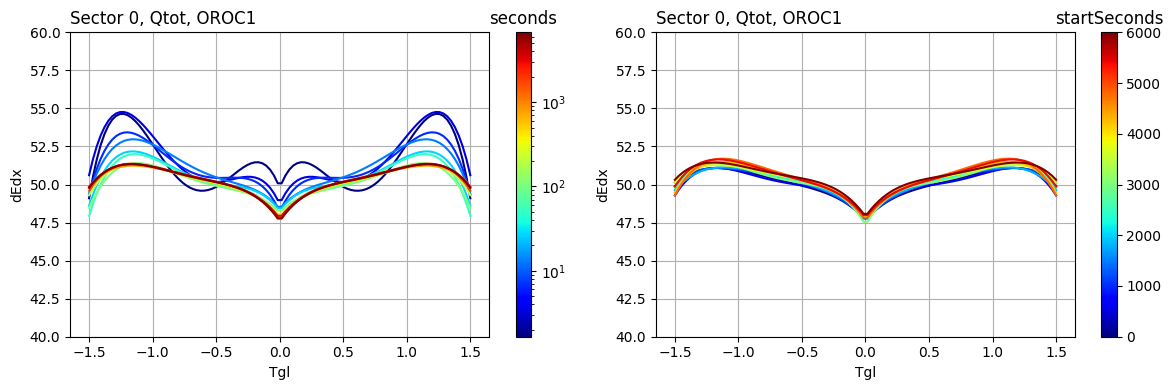

In [68]:
plt.figure(figsize=(12, 4), dpi=100)

idx = to_index(sector=0, roc=1, charge=1)
plt.subplot(121)
plotTgl(data, "seconds", idx, scale="log")

plt.subplot(122)
plotTgl(dataTime, "startSeconds", idx, scale="lin")
plt.tight_layout()

(20.0, 90.0)

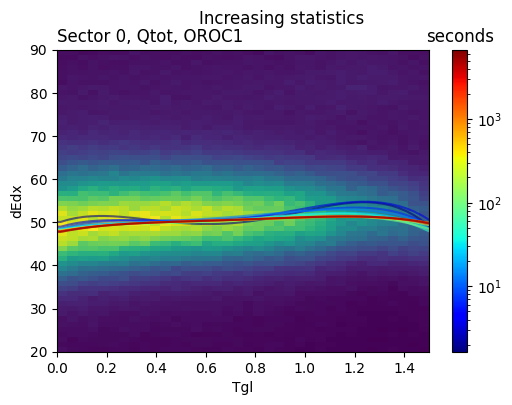

In [30]:
fig = plt.figure(dpi=100)
plotTgl(data, "seconds", idx, scale="log", hist=hist, alpha=0.6)
fig.suptitle("Increasing statistics");
plt.ylim(20, 90)

In [48]:
def plotSector(data, axis, sector, **kwargs):
    for charge in range(2):
        for roc in range(4):
            idx = sector + roc * 36 + charge * 144
            plt.subplot(2, 4, roc + charge * 4 +1)
            plotTgl(data, axis, idx, **kwargs)
            plt.xlim(-1.5, 1.5)
    plt.tight_layout()

505658

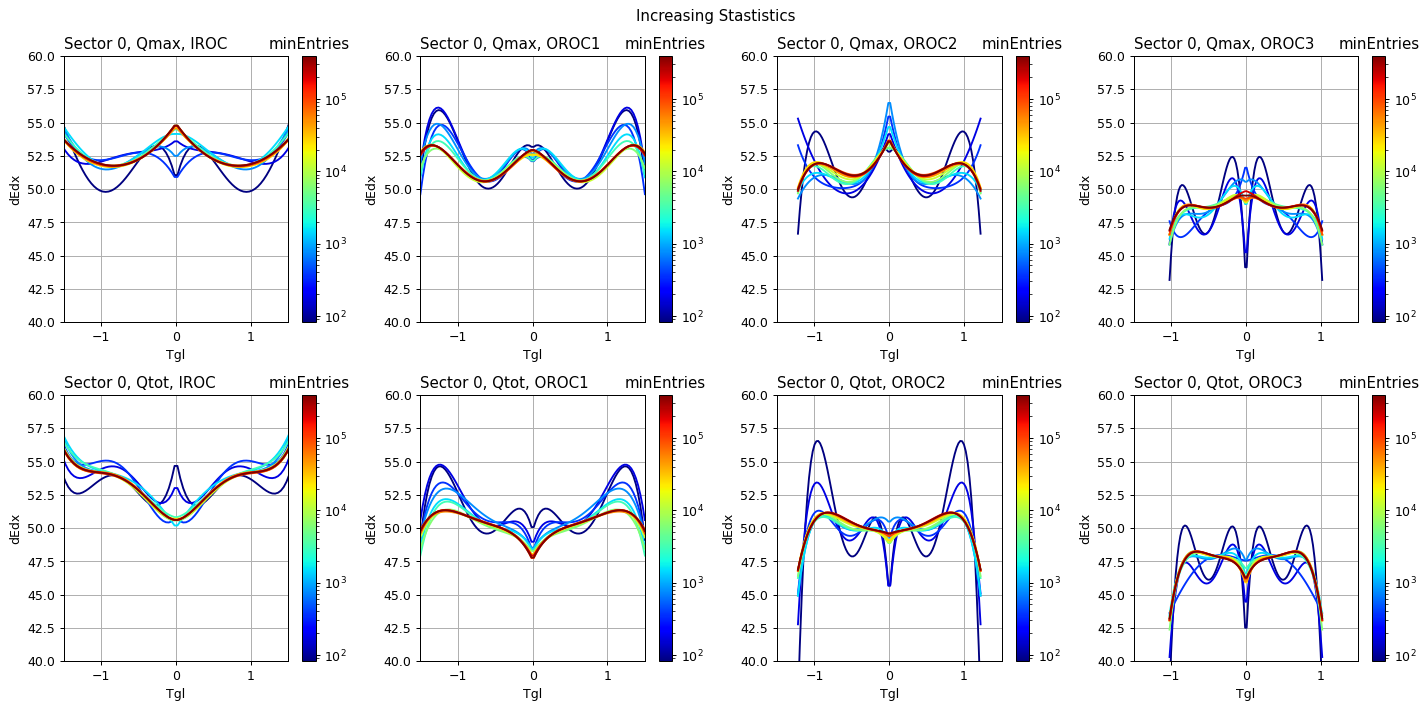

In [49]:
fig = plt.figure(figsize=(16, 8), dpi=90)
fig.suptitle("Increasing Stastistics")
plotSector(data, "minEntries", 0, scale="log")

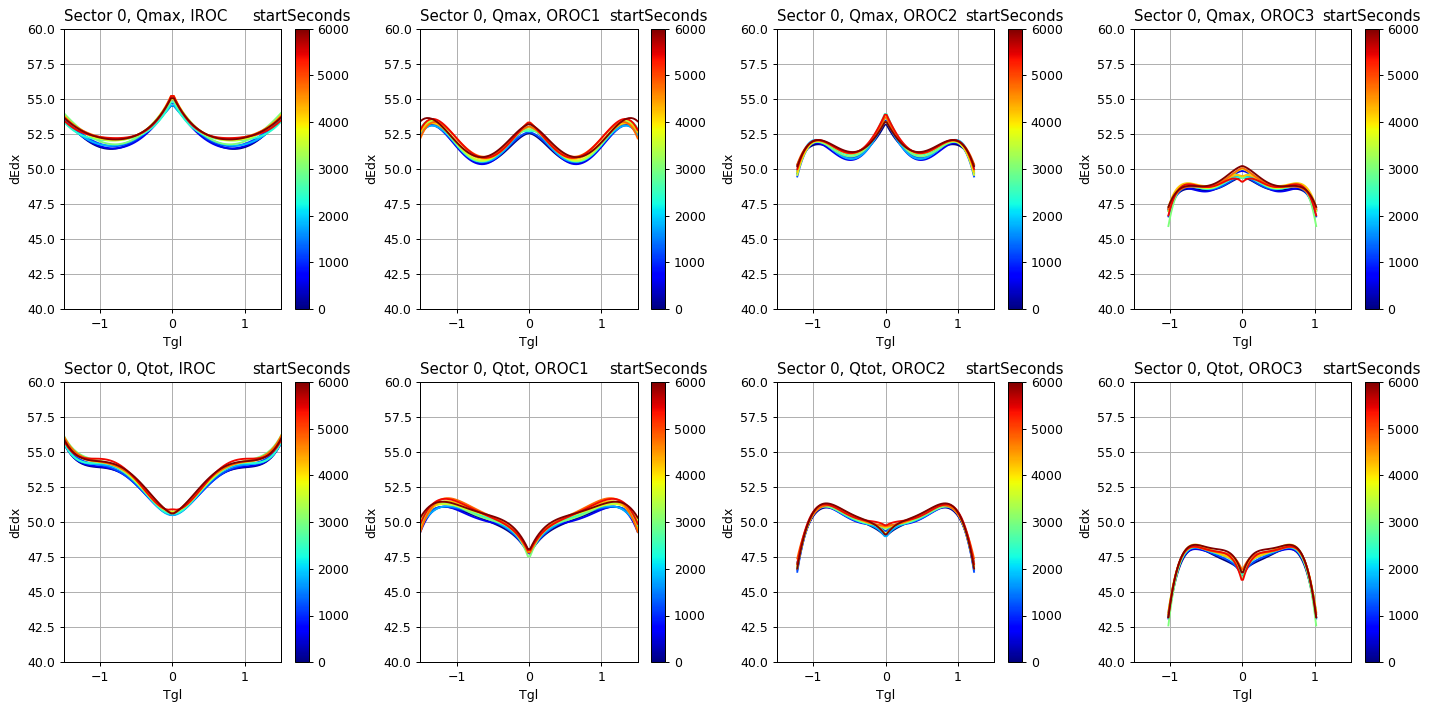

In [67]:
fig = plt.figure(figsize=(16, 8), dpi=90)
# fig.suptitle("Increasing Stastistics")
plotSector(dataTime, "startSeconds", 0, scale="lin")

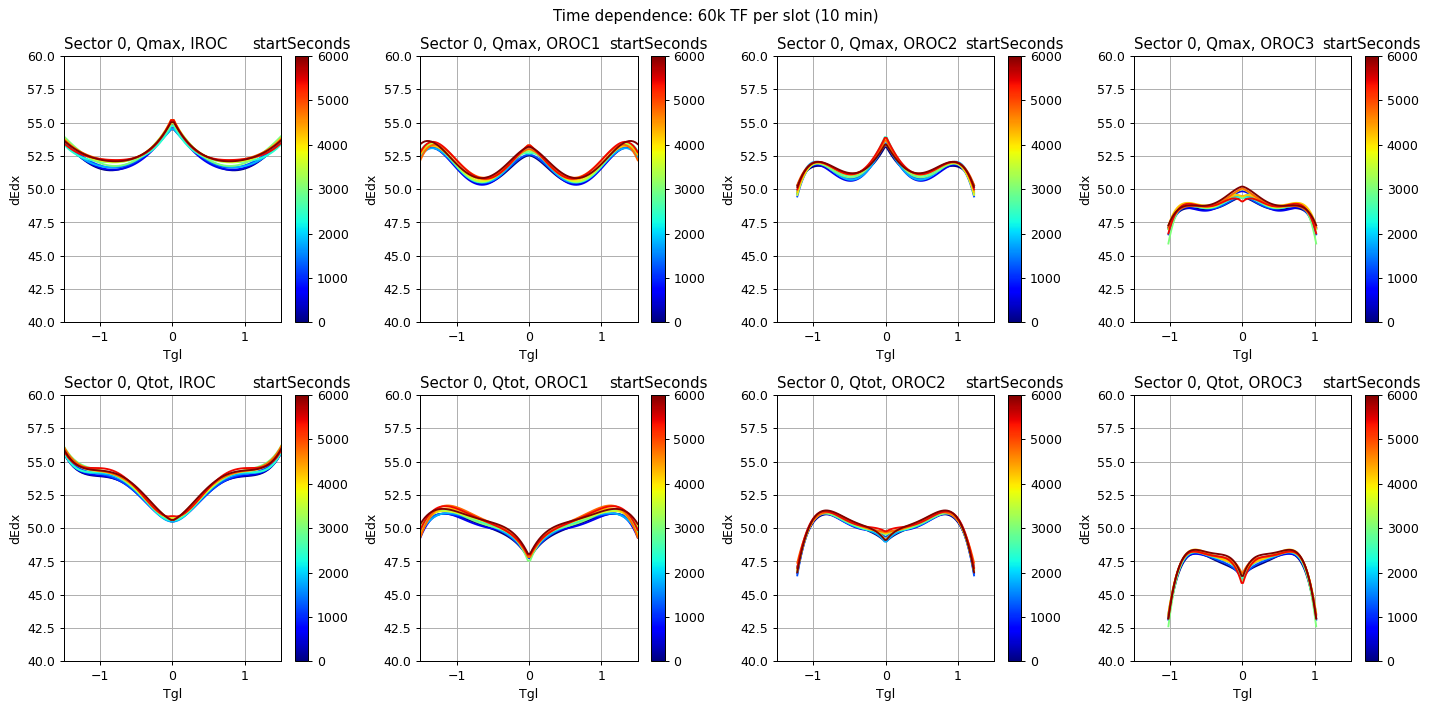

In [69]:
fig = plt.figure(figsize=(16, 8), dpi=90)
fig.suptitle("Time dependence: 60k TF per slot (10 min)")
plotSector(dataTime, "startSeconds", 0, scale="lin")

In [65]:
idx = to_index(0, 0, 1)
axis = "seconds"
sm = plt.cm.ScalarMappable(cmap="jet", norm=LogNorm(vmin=data[axis].min()/2, vmax=data[axis].max()))

for i in range(data.shape[0]):
    tmp_data = data.iloc[:i+1]
    plotTgl(tmp_data, axis, idx, scale=sm)
    plt.text(0, 42.5, f"Seconds: {tmp_data.seconds.max():.1f}\nminEntries: {tmp_data.minEntries.max()}", horizontalalignment='center')
    plt.savefig(f"stat-{i:02d}.png", dpi=100)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [64]:
idx = to_index(0, 0, 1)
axis = "startSeconds"
sm = plt.cm.ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=dataTime[axis].min()/2, vmax=dataTime[axis].max()))

for i in range(dataTime.shape[0]):
    tmp_data = dataTime.iloc[:i+1]
    plotTgl(tmp_data, axis, idx, scale=sm)
    plt.text(0, 42.5, f"startSeconds: {tmp_data[axis].max():.1f}", horizontalalignment='center')
    plt.savefig(f"time-{i:02d}.png", dpi=100)
    plt.clf()

<Figure size 432x288 with 0 Axes>

## Benchmark
### Normal execution
#### dEdxbin = 60; TglBins = 36
Bins = 622k
- Fitting 1D dE/dx correction for GEM stacks
- **Fill time: 189.918 s**
- Fill time per track: 0.0026284 ms
- Fit time: 0.448453 s
- Total number of track entries: 6357910. Min. entries per GEM stack: 115635

### Null bins
#### dEdxbin = 1; TglBins = 1
Bins = 288

- Fitting 1D dE/dx correction for GEM stacks
- **Fill time: 185.192 s**
- Fill time per track: 0.00256298 ms
- Fit time: 0.0190078 s
- Total number of track entries: 6357910. Min. entries per GEM stack: 115635